# Measuring Uncertainty of a Success Rate
The observed data in this kind of application is raw data of 1's and 0's which represent successes and failures, respectively. In real-world applications we usually see this binary data aggregated at a higher level (e.g., daily, weekly, monthly) as counts of successes and failures. The uncertaintly of the success rate which produced the data is measured with the Beta distribution. The Beta distribution has two parameters: alpha (number of observed successes) and beta (number of observed failures). In the example below, I capitalize the Beta distribtion to differentiate it from its own beta parameter.


### Exercise 1: Measuring a Success Rate

In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, to_rgb
import scipy.stats as stats

#### Generate Data
Generate 1,000 random success and failture observations over the last 30 days

In [7]:
end = datetime.now()
start = end - pd.Timedelta('30 days')
days = pd.date_range(start=start, end=end).to_period('d')

# Randomly choose a secret success rate
p = np.random.random(1)[0]

raw_data = pd.Series(
    data=stats.bernoulli.rvs(p=p, size=1000),
    index=np.random.choice(a=days, size=1000)
).sort_index()

#### Aggregate Data
Aggregate successes and failures to the daily level  
This is not required, but mirrors how you would measure a success rate in the real world

In [8]:
daily_data = raw_data.groupby(level=0).value_counts() \
    .unstack() \
    .rename(columns={0: "failures", 1: "successes"})

daily_data.head()

,failures,successes
2024-03-29,9,15
2024-03-30,10,23
2024-03-31,15,19
2024-04-01,14,22
2024-04-02,9,23


#### Bayesian Analysis: Daily Updates
A nice feature of Bayesian analysis is that it can be done in real-time as new data is comming in. Even though the 2022 NBA season has already occured, let's pretend we're analyzing our data as it comes in an save these  cumulative snapshots game by game:

In [9]:
cumulative_updates = []

# Set weak priors for alpha and beta
a = 1
b = 1

for date, data in daily_data.iterrows():

    # Update the priors with daily data
    a += data['successes']
    b += data['failures']

    # Update our beta distribution with new a & b params
    cumulative_distribution = stats.beta(a=a, b=b)

    # Append update to list for further analysis
    cumulative_updates.append({
        "date": date,
        "cumulative_distribution": cumulative_distribution})


#### Bayesian Analysis: Visualize Updates

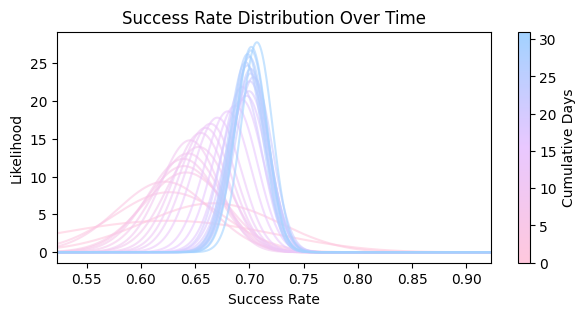

In [12]:
success_rates = np.linspace(0, 1, 1001)
analysis = pd.DataFrame()

for i, update in enumerate(cumulative_updates):
    date = update["date"]
    distribution = update["cumulative_distribution"]
    
    rate_likelihoods = pd.Series(
        data=distribution.pdf(success_rates),
        index=success_rates)

    analysis[f"{i+1} Day(s)"] = rate_likelihoods

hex_colors = ['#ffc8dd', '#e9c8ff', '#a2d2ff']
rgb_colors = rgb_colors = [to_rgb(color) for color in hex_colors]
cmap = LinearSegmentedColormap.from_list("my_colormap", rgb_colors)
ax = analysis.plot(
    title="Success Rate Distribution Over Time", 
    cmap=cmap, 
    legend=False, 
    xlabel="Success Rate",
    ylabel="Likelihood",
    xlim=(max(0, p - .2), min(p + .2, 1)),
    alpha=.6, 
    figsize=(7,3));

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=analysis.shape[1]))
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax)
cbar.ax.set_ylabel("Cumulative Days");

In [13]:
print("95% CI:", cumulative_updates[-1]["cumulative_distribution"].interval(.95))
print("Actual success rate:", p)

95% CI: (0.6780255753781866, 0.7343669634727266)
Actual success rate: 0.7226557551642395


### Excercise 2: Comparing Success Rates

#### Create Second Dataset

In [14]:
# Secretly choose random success rates
p_A = np.random.random(1)[0]
diff = np.random.uniform(low=-.1, high=.1, size=1)[0]
p_B = p_A + diff

# Generate the raw data
raw_data_A = pd.Series(
    data=stats.bernoulli.rvs(p=p_A, size=1000),
    index=np.random.choice(a=days, size=1000)
).sort_index()

raw_data_B = pd.Series(
    data=stats.bernoulli.rvs(p=p_B, size=1000),
    index=np.random.choice(a=days, size=1000)
).sort_index()

# Aggregate data by day
daily_data_A = raw_data_A.groupby(level=0).value_counts() \
    .unstack() \
    .rename(columns={0: "failures", 1: "successes"}) \
    .fillna(0)

daily_data_B = raw_data_B.groupby(level=0).value_counts() \
    .unstack() \
    .rename(columns={0: "failures", 1: "successes"}) \
    .fillna(0)

#### Calculate Updates

In [15]:
cumulative_updates_AB = {}

# Set weak priors for alpha and beta
a_A, b_A = 1, 1
a_B, b_B = 1, 1

for date in days:

    data_A = daily_data_A.loc[date]
    data_B = daily_data_B.loc[date]

    # Update the priors with daily data
    # Group A
    a_A += data_A['successes']
    b_A += data_A['failures']
    # Group B
    a_B += data_B['successes']
    b_B += data_B['failures']

    # Update our beta distributions with new a & b params
    cumulative_distribution_A = stats.beta(a=a_A, b=b_A)
    cumulative_distribution_B = stats.beta(a=a_B, b=b_B)

    # Append update to list for further analysis
    cumulative_updates_AB[date] = {
        'A': cumulative_distribution_A,
        'B': cumulative_distribution_B}


#### P(raw_data_2 > raw_data)
There are multiple ways to compute this probability, but the most straight-forward to is draw a bunch of samples from each player's distribution and compare the number of times Curry's 3P rate is higher than Dončić's.

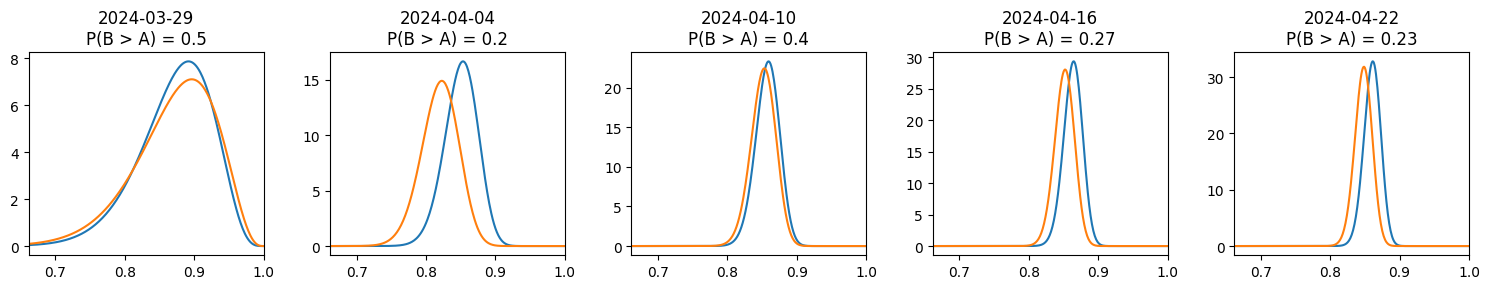

In [20]:
fig, axs = plt.subplots(1, 5, figsize=(15,3))

# Graph updated distributions every six days
checkin_dates = days[::6]

for idx, ax in enumerate(axs.flatten()):
    date = checkin_dates[idx]
    distribution_A = cumulative_updates_AB[date]['A']
    distribution_B = cumulative_updates_AB[date]['B']
    # Generate 1 million samples from each distribution
    simulation_A = distribution_A.rvs(size=1_000_000)
    simulation_B = distribution_B.rvs(size=1_000_000)
    # Compare samples to approximate P(B > A)
    p_B_gt_A = round((simulation_B > simulation_A).sum() / 1_000_000, 2)

    rate_likelihoods_A = pd.Series(data=distribution_A.pdf(success_rates), index=success_rates)
    rate_likelihoods_B = pd.Series(data=distribution_B.pdf(success_rates), index=success_rates)

    title = f"{date}\nP(B > A) = {p_B_gt_A}"
    rate_likelihoods_A.plot(title=title, ax=ax)
    rate_likelihoods_B.plot(title=title, ax=ax, xlim=(max(0, p_A - .2), min(p_A + .2, 1)))

plt.tight_layout()

In [17]:
print("Success rate A:", p_A)
print("Success rate B:", p_B)

Success rate A: 0.8615292301799472
Success rate B: 0.8442829352439305
